In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots as sbp
import sys
sys.path += ["../src"]
import jl_vae
from glob import glob
from jl_synthetic_pop_all_provinces import add_cat_features
from tqdm import tqdm
from _51_abm_functions import cod_prov_abbrv_df
import utils
import geopandas as gpd
import config

In [3]:
census = gpd.read_file(config.census_hydro_risk_path).to_crs('EPSG:3035') 
census['PRO_COM_formated'] = census['PRO_COM'].apply(lambda x: '{:06d}'.format(int(x)))
census=census.drop(columns = 'PRO_COM').rename(columns={'PRO_COM_formated':'PRO_COM'})
census = census.loc[:,['SEZ2011','PRO_COM','geometry']] 
census['SEZ2011'] =census['SEZ2011'].astype(str)

geo_dict = jl_vae.load_geo_data()


In [4]:

print("available provinces")
[u.split("_")[-1][:2] for u in glob(jl_vae.path_pop_synth + f"copula_samples/df_copula_nf95_*.csv")]

available provinces


['AG',
 'TS',
 'PA',
 'BZ',
 'LO',
 'PV',
 'NO',
 'BN',
 'LE',
 'FC',
 'CS',
 'IM',
 'MO',
 'AL',
 'BI',
 'CO',
 'TE',
 'UD',
 'LI',
 'VC',
 'AR',
 'EN',
 'MS',
 'CN',
 'LU',
 'CH',
 'PE',
 'CA',
 'MT',
 'TN',
 'SO',
 'PR',
 'TV',
 'FR',
 'BL',
 'TR',
 'FG',
 'LC',
 'PN',
 'PT',
 'MC',
 'VI',
 'NU',
 'AN',
 'CE',
 'PI',
 'VT',
 'BT',
 'VV',
 'SI',
 'GR',
 'RE',
 'GO',
 'AP',
 'CZ',
 'SS',
 'PO',
 'KR',
 'AQ',
 'FM',
 'RI',
 'SV',
 'SR',
 'AT',
 'BR',
 'SA',
 'RO',
 'PU',
 'LT',
 'MN',
 'RA',
 'VR',
 'SP',
 'RC',
 'CR',
 'TA',
 'ME',
 'CL',
 'VB',
 'AV',
 'RG',
 'RN',
 'CT',
 'OR',
 'AO',
 'FE',
 'TP',
 'PC',
 'IS',
 'CB',
 'PZ']

In [13]:
prov = "AN"

In [14]:
cod_prov = cod_prov_abbrv_df.query("prov_abbrv == @prov")["COD_PROV"].iloc[0]

df_real = pd.read_csv(jl_vae.path_pop_synth + f"real_populations/df_real_{prov}.csv", index_col = 0)
df_real95 = df_real.sample(frac = 0.95, random_state = 1111)
df_excluded = df_real[~df_real.index.isin(df_real95.index)]


df_nfvae = pd.read_csv(jl_vae.path_pop_synth + f"pop_samples/synthetic_pop_full_250709price_{prov}.csv", index_col = 0)
df_vae = pd.read_csv(jl_vae.path_pop_synth + f"pop_samples_ablation/synthetic_pop_full_250710{prov}.csv", index_col = 0)

df_nfvae95 = pd.read_csv(jl_vae.path_pop_synth + f"95sample/pop_samples/synthetic_pop_full_250703{prov}.csv", index_col = 0)

df_copula_ablation = pd.read_csv(jl_vae.path_pop_synth + f"copula_samples/df_copula_ablation_{prov}.csv", index_col = 0)
df_copula_nf = pd.read_csv(jl_vae.path_pop_synth + f"copula_samples/df_copula_nf_{prov}.csv", index_col = 0)
df_copula_ablation95 = pd.read_csv(jl_vae.path_pop_synth + f"copula_samples/df_copula_ablation95_{prov}.csv", index_col = 0)
df_copula_nf95 = pd.read_csv(jl_vae.path_pop_synth + f"copula_samples/df_copula_nf95_{prov}.csv", index_col = 0)

df_ipf = pd.read_csv(jl_vae.path_pop_synth + f"ipf_samples/df_sample_{prov}_250718.csv", index_col = 0)
df_ipf95 = pd.read_csv(jl_vae.path_pop_synth + f"ipf_samples/df_sample95_{prov}_250718.csv", index_col = 0)

census_filter = census.assign(prov_cod = lambda x: [u[:3] for u in x["PRO_COM"]]).query("prov_cod == @cod_prov")
polyg = census_filter[["prov_cod", "geometry"]].dissolve().to_crs('EPSG:4326')




In [18]:
df_copula_nf = pd.read_csv(jl_vae.path_pop_synth + f"copula_samples/df_copula_nf_{prov}.csv", index_col = 0)
df_copula_nf = (utils.spatial_matching_ABM(df_copula_nf,
                            hydro_risk = geo_dict["hydro_risk"],
                            census = geo_dict["census"],
                            omi_og = geo_dict["omi_og"],
                            cap = geo_dict["cap"])
                            .rename(columns = {"GEO_LONGITUDINE_BENE_ROUNDED":"x", "GEO_LATITUDINE_BENE_ROUNDED":"y"})
                            .sample(n = len(df_real), random_state = 1807, replace = True)
                            .query("prov_abbrv == @prov")
                            )
df_sample95 = df_copula_nf.sample(frac = 0.95, random_state = 11)
df_excluded = df_copula_nf.loc[~df_copula_nf.index.isin(df_sample95.index)]

# df_ipf = pd.read_csv(jl_vae.path_pop_synth + f"ipf_samples/df_sample_{prov}_250718.csv", index_col = 0)
# df_ipf = (utils.spatial_matching_ABM(df_ipf,
#                             hydro_risk = geo_dict["hydro_risk"],
#                             census = geo_dict["census"],
#                             omi_og = geo_dict["omi_og"],
#                             cap = geo_dict["cap"])
#                             .rename(columns = {"GEO_LONGITUDINE_BENE_ROUNDED":"x", "GEO_LATITUDINE_BENE_ROUNDED":"y"})
#                             .sample(n = len(df_real), random_state = 1807, replace = True)
#                             .query("prov_abbrv == @prov")
#                             )



In [15]:
all_baselines = {"df_real": df_real, 
                 "df_real95": df_real95, 
                 "df_nfvae": df_nfvae, 
                 "df_vae": df_vae, 
                 "df_nfvae95": df_nfvae95, 
                 "df_copula_ablation": df_copula_ablation,
                 "df_copula_nf": df_copula_nf, 
                 "df_copula_ablation95": df_copula_ablation95, 
                 "df_copula_nf95": df_copula_nf95, 
                 "df_ipf": df_ipf,
                 "df_ipf95": df_ipf95}
                 

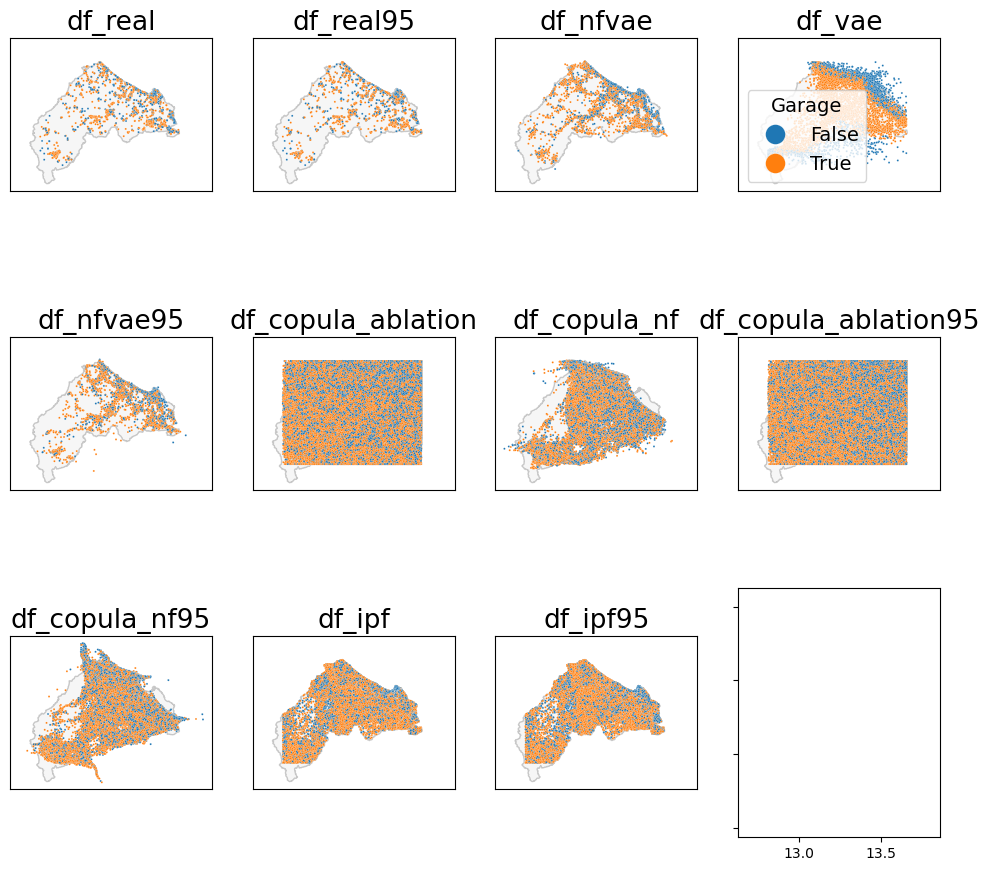

In [16]:
fig, axes = sbp(ncols = 4, nrows = 3, figsize = (12,11), sharex = True, sharey = True)

for k,fun in enumerate(all_baselines):
    i,j = divmod(k,4)

    polyg["geometry"].plot(ax = axes[i,j], color = "lightgrey", alpha = 0.2, edgecolor = "black")

    df_plot = all_baselines[fun]
    # if fun not in ["df_real", "df_real95"]:
    #     df_plot = (utils.spatial_matching_ABM(df_plot,
    #                         hydro_risk = geo_dict["hydro_risk"],
    #                         census = geo_dict["census"],
    #                         omi_og = geo_dict["omi_og"],
    #                         cap = geo_dict["cap"])
    #                         .rename(columns = {"GEO_LONGITUDINE_BENE_ROUNDED":"x", "GEO_LATITUDINE_BENE_ROUNDED":"y"})
    #                         .sample(n = len(df_real), random_state = 1807, replace = True)
    #                         .query("prov_abbrv == @prov")
    #                         )
    
    sns.scatterplot(data = df_plot.assign(flag_garage = lambda x: (x["flag_garage"] + 0.) > 0),
                    hue = "flag_garage", 
                    # hue = "flag_garage", 
                    x = "x", y = "y", s = 2, ax = axes[i,j])
    # axes[j].set_title(prov + " " + ["Real", "Synthetic"][j])
    axes[i,j].set_title(fun, fontsize = 19)
    axes[i,j].get_xaxis().set_visible(False)
    axes[i,j].get_yaxis().set_visible(False)
    axes[i,j].legend().set_visible(False)
axes[0,3].legend(fontsize = 14, markerscale = 10, title_fontsize = 14).set_title("Garage")        
    


In [54]:
# for prov in tqdm(cod_prov_abbrv_df.sort_values("prov_abbrv")["prov_abbrv"]):
#     try:
#         df_real = jl_vae.get_df_prov(prov, dropna = False, add_cols = ["log_price"])
#         df_real = df_real[[u for u in jl_vae.cols + ["log_price"] if u not in ["prov_abbrv"]] + ["x_norm", "y_norm"]].assign(flag_air_conditioning_Missing = lambda x: x["flag_air_conditioning"] == "Missing",
#                                                                                                                                     flag_multi_floor_Missing = lambda x: x["flag_multi_floor"] == "Missing").replace("Missing",0).astype(float)
#         df_real.drop(columns = [u for u in ["flag_geo_valid"] if u in df_real.columns], inplace = True)
        
#         df_real_geo = utils.spatial_matching_ABM(df_real, geo_dict["hydro_risk"], geo_dict["census"], 
#                                           geo_dict["omi_og"], geo_dict["cap"]).rename(columns = {"GEO_LATITUDINE_BENE_ROUNDED": "y", "GEO_LONGITUDINE_BENE_ROUNDED": "x"})
#         df_real_geo.drop(columns = [
#             'x_norm', 'y_norm', 'COD_CONTRATTO',
#             'flag_geo_valid', 'OMI_categ', 'scenario',
#             'scenario_HighRisk', 'scenario_LowRisk', 'scenario_MediumRisk',
#             'scenario_NoRisk', 'scenario_Risk', 'flag_italy', 'COD_PROV', 'COD_REG',
#             'regione_nome', 'prov_nome', 'year_erogaz_prov'], inplace = True)
#         df_real_geo.to_csv(f"/data/housing/data/intermediate/jl_pop_synth/real_populations/df_real_{prov}.csv")
#     except:
#         print(prov)

In [ ]:
from pyfixest.estimation import feols

In [ ]:
cols_hedonic_reg = ['flag_garage', 'flag_pertinenza', 'flag_air_conditioning',
       'flag_multi_floor', 'log_mq', 'ANNO_COSTRUZIONE_1500_1965',
       'ANNO_COSTRUZIONE_1965_1985', 'ANNO_COSTRUZIONE_1985_2005',
       'ANNO_COSTRUZIONE_2005_2025', 'ANNO_COSTRUZIONE_Missing',
       'High_energy_class', 'Low_energy_class', 'Medium_energy_class',
       'Missing_energy_class', 'COD_CAT_A02', 'COD_CAT_A03',
       'COD_CAT_A_01_07_08', 'COD_CAT_A_04_05', 'floor_0.0', 'floor_1.0',
       'floor_2.0', 'floor_3.0', 'floor_Missing', 'floor_plus_4',
       'flag_air_conditioning_Missing', 'flag_multi_floor_Missing']

In [ ]:
eq_hedonic_reg = f'log_price ~ {" + ".join(cols_hedonic_reg)}'

In [ ]:
reg_risk_all = {baseline: feols(fml = eq_hedonic_reg, data = all_baselines[baseline], drop_intercept=False )
                for baseline in all_baselines if "95" not in baseline}

In [ ]:
coefs_baselines = pd.DataFrame({baseline: reg_risk_all[baseline].coef() *  (reg_risk_all[baseline].pvalue() < 0.05) for baseline in reg_risk_all}).fillna(0)

In [9]:
mean_col_baselines = pd.DataFrame({baseline: all_baselines[baseline][cols_hedonic_reg].mean() for baseline in all_baselines if "95" not in baseline})

<Axes: >

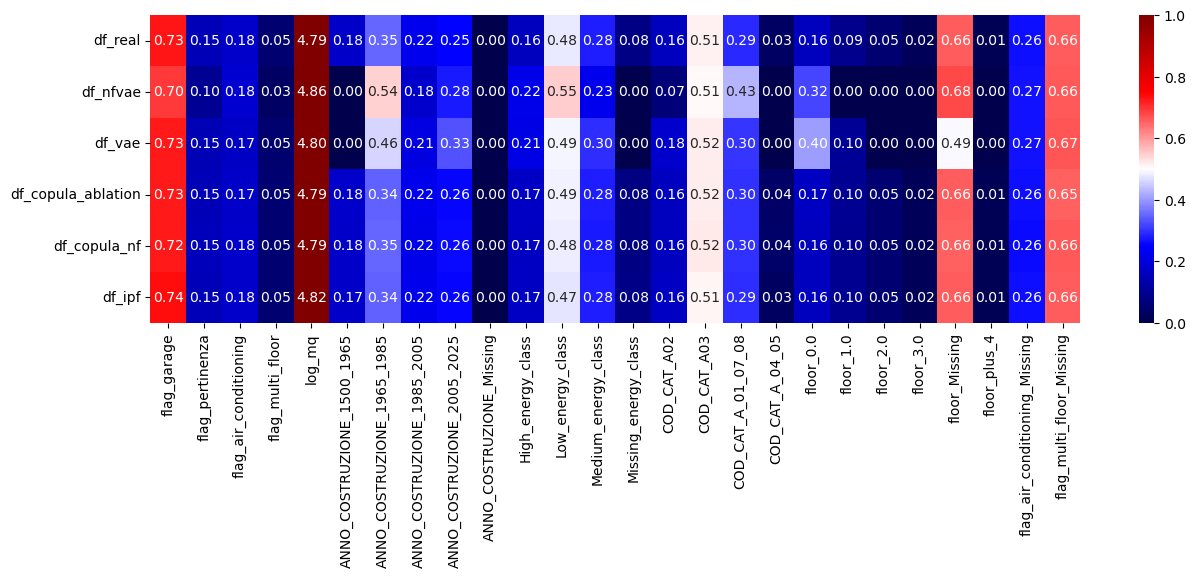

In [10]:
fig, axes = sbp(figsize = (15,4))
sns.heatmap(mean_col_baselines.T, vmin = 0, vmax = 1, cmap = "seismic", annot = True, fmt = ".2f")

<Axes: xlabel='Coefficient'>

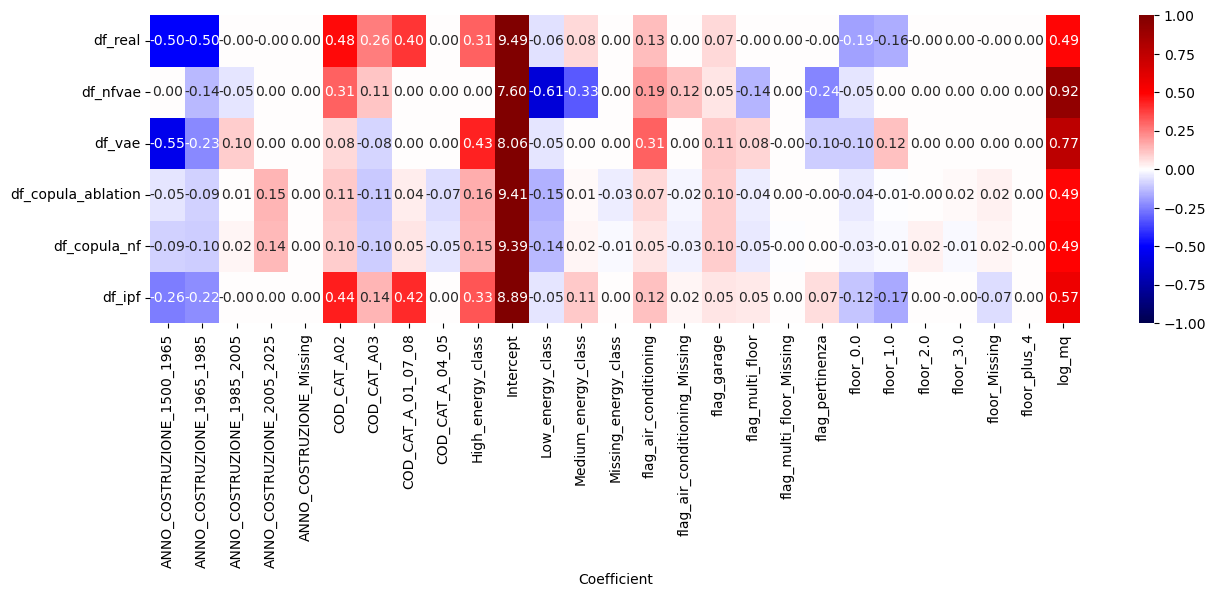

In [148]:
fig, axes = sbp(figsize = (15,4))
sns.heatmap(coefs_baselines.T, vmin = -1, vmax = 1, cmap = "seismic", annot = True, fmt = ".2f")